**To create a Time Series model to predict the future passengers traffic**

In [58]:
## importing libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [59]:
## Loading the dataset
data= pd.read_csv("AirPassengers.csv")

# we have data of airline passengers travelled from Jan 1949 to Dec 1960

In [60]:
data.shape

(144, 2)

In [61]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [63]:
# Month is given as string here,
# we need to convert that into date-time format


In [64]:
# Parse dastes: Parsing the date (converts the string representation of a data to Date object)
# index_col: using date column as index

data= pd.read_csv("AirPassengers.csv", parse_dates=[0], index_col="Month")

# NOTE:
# we are converting the month column into index--> because we need only passengers feature here for time series analysis

### **Basic checks**

In [65]:
data.head()
# now month column is the index

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [66]:
data.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [67]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### **EDA**

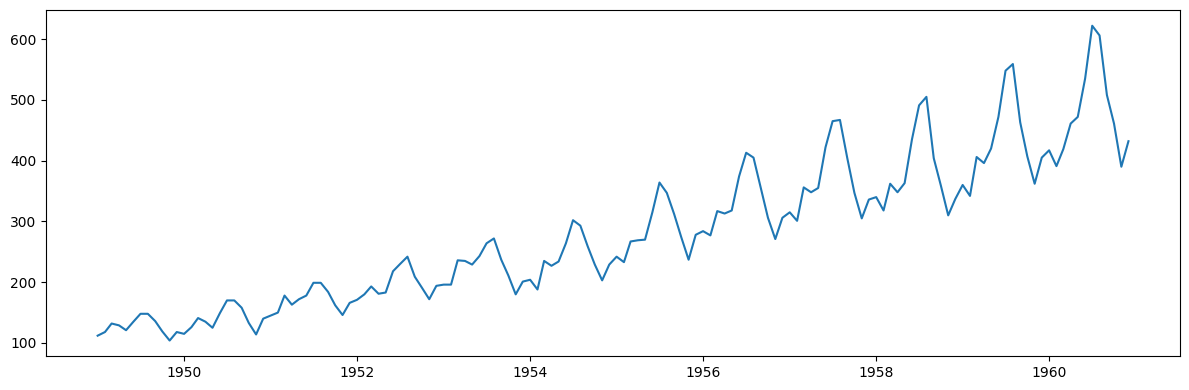

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize= (12, 4), facecolor= 'w')
plt.plot(data) # lineplot
plt.tight_layout()
plt.show()

# From this plot, the data is non-stationary

In [69]:
# we can also check the autocorrelation function (ACF)     plot to check if the series is stationary
from statsmodels.graphics.tsaplots import plot_acf

**✅ Why Give lags=40 in plot_acf or plot_pacf?**

🔹 Because you're asking:
"Show me how far back my current value is significantly correlated with its past values — up to how many time steps?"

So:

**If you're modeling monthly data (like the AirPassengers dataset), lags=40 = 40 months = ~3.3 years**

**That’s enough to reveal:**

- Short-term structure (lags 1–12)
- Seasonal effects (lags 12, 24, etc.)
- Longer dependencies, if any

**What if you don't specify lags?**
Then:

***plot_acf(data)***
Defaults to:
***lags = min(10, len(data) // 5)***
So if you have 100 data points, you'll only get lags up to 10 — potentially missing seasonal patterns or longer-term lags.

🔍 **Real-World Implication**
Say your data has:

- Strong yearly seasonality (like air passengers → peak in December)

If You don’t specify lags

- ACF/PACF only shows lag 1 to 10 → ❌ You miss lag 12 spike

- You build a weak AR model that doesn’t account for seasonality

🧠 Model fails to capture real-world behavior.

🎯 **Strategic Lag Rule-of-Thumb**
Data Frequency-->	Recommended lags for ACF/PACF
- Daily	30–90 (to catch weekly/monthly)
- Monthly	36–48 (to catch annual cycles)
- Quarterly	12–20

🧠 TL;DR
Give lags=40 for monthly data to spot both short-term and seasonal relationships

Don't omit lags unless you're just doing a quick glance

Always tie lags to the frequency and domain knowledge of your time series


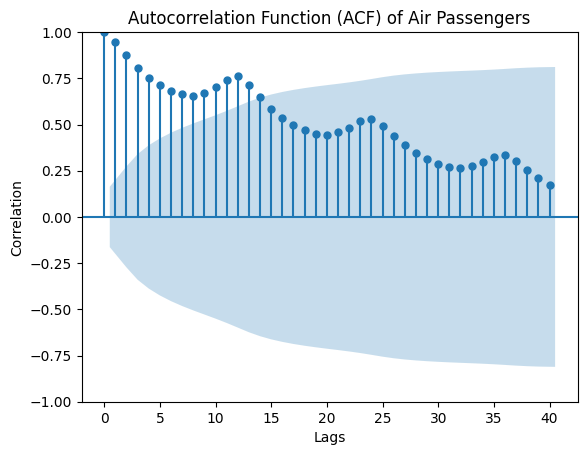

In [70]:
plot_acf(data, lags= 40)
plt.title('Autocorrelation Function (ACF) of Air Passengers')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [71]:
# Since the data is non=stationary, 👉differencing is done!--> differencing of order 1
# Then the stationarity is checked.
# If still non-stationary, go for the differncing of order 2

In [72]:
# Differencing of order 1
data_diff1= data.diff(periods= 1)

In [73]:
data_diff1

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0
...,...
1960-08-01,-16.0
1960-09-01,-98.0
1960-10-01,-47.0


In [74]:
# Remove the 1st row (Nan- due to the diff of order 1)
data_diff1= data_diff1.iloc[1:]
data_diff1

,#Passengers
Month,
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0
1949-06-01,14.0
...,...
1960-08-01,-16.0
1960-09-01,-98.0
1960-10-01,-47.0


In [75]:
# After removing the first row
len(data_diff1) 

143

In [76]:
# Plotting the ACF again with the new series(data_diff1) as function of time lag between them

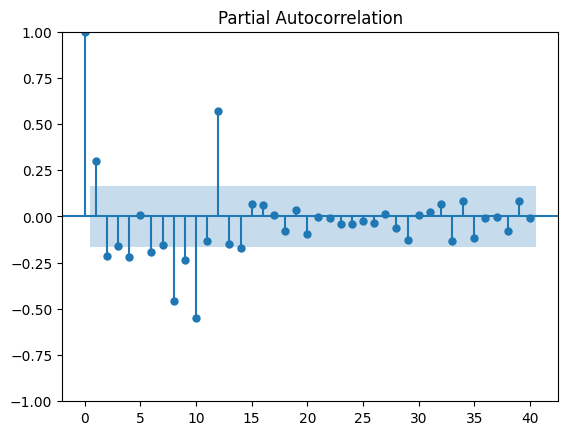

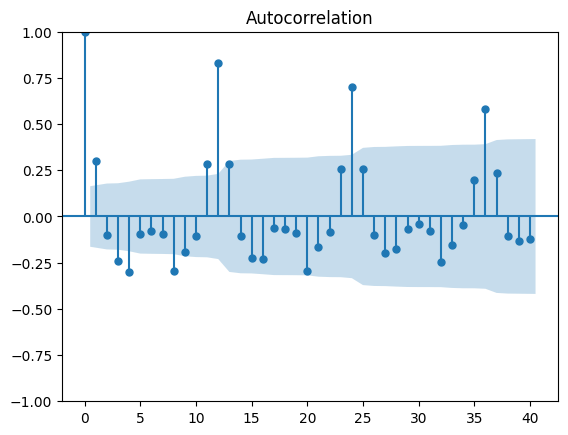

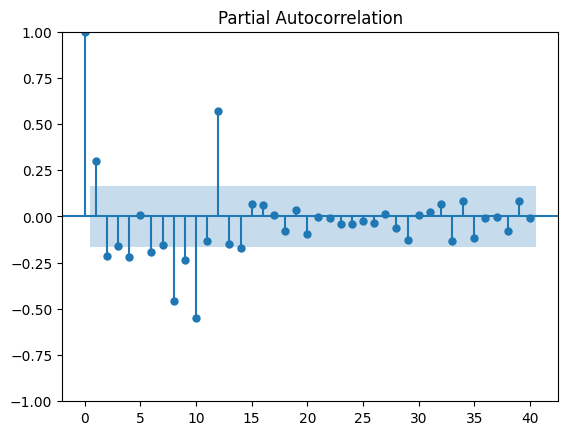

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_diff1, lags=40)
plot_pacf(data_diff1, lags=40)

**ACF Vs PACF in Time Series**

**ACF (Autocorrelation Function)**
- It tells --> How correlated is the time series with its past values at lag 1, 2, 3..?
- It ***includes both direct and indirect effects***
  - For example: 
    - If ACF at lag 3 = correlation between y(t) and y(t-3)
     but it also includes the indirect influence via y(t-2), y(t-1).

**PACF (Partial Autocorrelation Function)**
- It tells --> what is the pure correlation between y(t) and y(t-k), after removing the effects of lags 1 to k-1 ?
- It measures the **direct effect of lag k, controlling for all lower lags**.


**DIFFERENCE IN SIMPLE TERMS**
- Concept--->ACF(Autocorrelation), 👉  PACF(Partial Autcorrelation)
- Measures--> Total correlation,   👉  Direct correlation
- Includes--> Direct + Indirect effects, 👉 Only direct effects
- Used for--> Identifying MA(q) models, 👉 Identifying AR(p) models

**HOW ARE THEY USEFUL ?**
- For fitting AR model(AutoReg),
  - Use PACF to identify the correct number of lags(p) 
    - Look for the last significant spike (outside the confidence band)
    - That lag is a good candidate for p (AR order).

- For fitting MA models,
  - Use ACF

In [78]:
# Observation:
# There is a few significiant spikes in lags and fast decline--> hence the series become stationary

In [79]:
# Creating and training and testing sets

# we cannot use train_test_split as it will randomly take the records for both the set
# But in time series, we take records in the given order only. (since every new value depends on the past values)


## Train and test split

In [80]:
train_data= data_diff1[:100] #  - taken as training data (note index 0 is already removed)

test_data= data_diff1[100:] # - testing data


In [81]:
train_data.shape

(100, 1)

In [82]:
test_data.shape

(43, 1)

## Applying autoregressive model

In [83]:
import warnings
warnings.filterwarnings("ignore")

- This is monthly data (we took train_data  for 100 rows so for 100 months~ 8 years)
- If we see the plot, we can the seasonal spikes at the end of each year like 12, 24 etc
- so to capture seasonal harmonics we have to give minimum 1 year(lag 12)
to around lags 24 or 36 
- But not too high to avoid overfitting here since we have only 100 rows

In [84]:
# Lag selection (finding optimal lag order values )and model fit
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

In [85]:
# Conservative upper bound to avoid overfitting
max_lag = min(36, len(train_data) // 2)  # 36 months OR half the data

# order = ar_select_order(train_data, maxlag=max_lag, ic='aic', glob=True)

# 👆If glob = True means Global Subset Selection--> it tries all the combinations of lags upto maxlag and 
# gives out the best subset (like feature selection) using AIC ,
#   it's like 2^36 ~= 68.7 billion combinations so that much hugh RAM allocation
#       will crash the process.


# 🧠 Pro Tip: Use glob=True only if:
# You have < 15 lags
# You suspect only some lags are useful
# You have enough RAM
# You want the most accurate subset model and can afford compute time

# ❌ Avoid it when:
# maxlag > 15 → Memory explodes (2^15 = 32,768 subsets)
# You have limited RAM
# You just need a quick, solid AR model (use glob=False)

order = ar_select_order(train_data, maxlag=max_lag, ic='aic', glob=False)
print("Selected lags:", order.ar_lags)


# these are the specific lag orders (in time steps) selected by the ar_select_order()
# function as optimal for the AutoReg model.  

# So lag 1, lag2...lag10, lag12, lag 13, lag 15, lag 20 all these lag values will be selected and applied
# in the AR equation!

Selected lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


✅ **What Does glob=True mean in ar_select_order()?**
- **glob=True** = Global Subset Selection
This means:

- “Try all possible combinations of lag variables up to maxlag, and pick the best subset based on AIC/BIC.”

- So instead of just testing AR(1), AR(2), … AR(36), it tries:

  - [1]

  - [1, 2]

  - [1, 3]

  - [1, 2, 3]

  - [4, 12, 24]

...

- Every subset of lags up to maxlag

- This is called Best Subset Selection — extremely powerful, but combinatorially expensive.

**🤖 What Happens When glob=False?**
- “Only test full AR(p) models for p = 1 to maxlag (i.e., all lags up to p).”

- So:

  - Try AR(1): lags = [1]

  - Try AR(2): lags = [1, 2]

  - ...

  - Try AR(12): lags = [1, 2, ..., 12]

  - This is called sequential order selection — way faster and memory-safe.


In [86]:
# Except: Lags 5, 8, 9, 11, 14, 16–19 were not selected — 
# # either because they weren't statistically significant or added noise.

# This sparse selection is due to glob=True in ar_select_order(), 
# # which allows non-contiguous lag selection (like feature selection in ML).

⚙️ How to Interpret This Practically?

- lag 1 (yesterday) is most important — this is expected in most time series.

- lag 2, lag 3, lag 4: Short memory effects — e.g., momentum.

- lag 7, lag 14: Might hint at **weekly seasonality (if daily data)**.

- lag 20: Long memory — could capture **slow trends or long-term effects.**

These lags are the most statistically useful past values to predict the current differenced value, according to AIC (or other IC) used.

**maxlag**
- It defines the maximum number of lag steps to evaluate as ***potential features in the AutoReg model.***
  - Like "Try all combinations from lag1 up to lag 20 -- and pick the best subset based on the AIC/ BIC".

**How should you choose maxlag?**
- ✅ Rule of Thumb (Statistical & Practical)
1. Depends on data frequency
 - Daily data? --> Try maxlag= 30  (monthly pattern)
 - Hourly data? --> Try maxlag= 48 (2 days), maxlag= 168 (1 week)
 - Monthly data? --> Try maxlag = 12 (1 year)
2. Depends on data volume:
 - If you have only 100 points, maxlag= 50 will **overfit**
 - You need enough samples to estimate the coefficients reliably.
 - Safe upper bound: maxlag= len(train_data)// 10 to len(train_data) // 5
3. Depends on your goal:
 - Short-term memory: ?--> Lower lags(5-20)
 - Long-term trends? --> Include Higher lags (30 - 60+)
 - Just want best performance? --> Try a range of maxlag values, and pick the one with the lowest AIC/ BIC

🚨 **Pitfalls of blindly setting maxlag=20:**
Problem	--> What Happens
- Too low (e.g. 10)--> You miss important patterns (e.g., seasonality at lag 30)
- Too high (e.g. 100)--> Overfitting, slow computation, spurious correlations
- Just default to 20 -->May miss better models — you're leaving performance on the table

- Set it based on your data's length, frequency, and seasonal structure.

In [ ]:
# ✅ Pro-Level Strategy: Dynamic Lag Selection
# maxlag = min(40, len(train_data) // 5)
# order = ar_select_order(train_data, maxlag=maxlag, ic='aic', glob=True)

# Or if you suspect weekly/monthly seasonality in daily data:
# maxlag = 30 or 60  # Cover ~1–2 months

In [87]:
model= AutoReg(train_data, lags= order.ar_lags)
ar_m= model.fit()

In [88]:
# Predict future difference values (y_prediction--> using test_data)
pred_diff= ar_m.predict(start= test_data.index[0], end= test_data.index[-1])

In [89]:
# y_prediction
# prediction= ar_m.predict(start= 100, end= 142) # give the start index and end value index

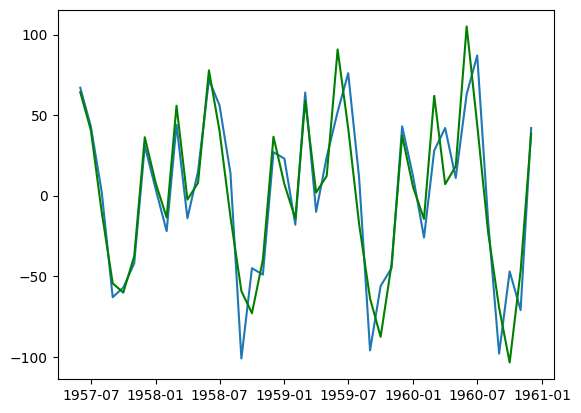

In [90]:
# comparing y_prediction and y_actual

plt.plot(test_data) # y_actual 
plt.plot(pred_diff, color= 'green') # y_prediction

**ARIMA MODEL**

In [91]:
# No need to do differencing since ARIMA model does this by default

In [94]:
# train, test data split
train= data[:100]
test= data[100:]

In [ ]:
# Importing the library

# from statsmodels.tsa.arima_model import ARIMA  (older version)
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# model object creation and fitting the model
model_arima= ARIMA(train, order=(2, 1, 2))  # (p, d, q) randomly give values for p, d, q

# p= autoregressive model
# d- how many times differencing is done (integrated order)
# q- moving average model

model_arima_fit= model_arima.fit() # training the model

In [97]:
# evaluate the model
print(model_arima_fit.aic) # Akaike Information Criterion (AIC) - lower the better


896.4336085163526


#### Is there a threshold for AIC in time series?
❌ No, there is no absolute threshold value for AIC (Akaike Information Criterion).

#### Resons:
- AIC is a relative metric, not an absolute one.
- You only use it to compare multiple models on the same dataset.
- **Lower AIC= better model** (in terms of balancing fit Vs compelxity)

#### ✅Example:
- If we compare ARIMA(1, 1, 0) Vs ARIMA(2, 1, 2)--> Pick the one with the lower AIC.
- Same model on different data --> ❌AICs are not comparable across datasets

#### Notes:
- AIC penalizes models with too many paramets --> **prevents overfitting**.
- AIC values can be negative too --> lower is still better
- If two models are very close in AIC (within 2 points), choose the simpler one.

In [98]:
# forecasting future values
# forecast() - forecasts data at a specific future point in time
# predict()- refers to future data in general, not at a specific time
forecast_9= model_arima_fit.forecast(steps= 9)  # # forecast for next 9 months since here each row represents monthly data

# The result of the forecast() function is an array containing the forecast value,
# the standard error of the forecast, and the confidence interval information.
# we are only intrested in the first element of this forecast.. so index 0 to take 1st value if we use the old method of initializing the model
# forecast_9[0] # gives the forecast value for the next 9 months (here no needed)

In [99]:
forecast_9

1957-05-01    326.745451
1957-06-01    332.367349
1957-07-01    328.516093
1957-08-01    328.951850
1957-09-01    328.110296
1957-10-01    328.010184
1957-11-01    327.778133
1957-12-01    327.696251
1958-01-01    327.618883
Freq: MS, Name: predicted_mean, dtype: float64

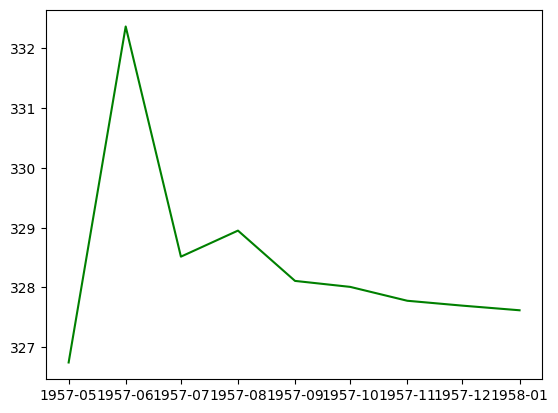

In [100]:
## plotting the forecasted values
plt.plot(forecast_9, color= 'green')

In [101]:
# Getting the optimal values of p, q and d

import itertools

p= d= q= range(0, 4)  # Example range for p, d, q (0 to 3) for every value of p, d, q , eg, (0,0,0), (0, 0, 1) etc

pdq= list(itertools.product(p, d, q)) # is used to find the cartesian  product from the given iterator,
pdq # list of all possible combinations of p, d, q values

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 3, 0),
 (3, 3, 1),
 (3, 3, 2),
 (3, 3, 3)]

In [102]:
import warnings
warnings.filterwarnings("ignore")

# The python try-- except statement is used to handle exceptions (errors) gracefully
# It is used to test code for errors and execute the exception block if an error occurs.

for params in pdq:
    try:
        model_arima= ARIMA(train, order= params) # training model on various pdq values
        model_arima_fit= model_arima.fit() # training
        print(params, model_arima_fit.aic) # printing the parameter and aic values
    except:
        continue
# The above code will try to fit the ARIMA model with different combinations of p, d, q values.
# If it fails (due to non-invertibility or other issues), it will skip that combination and continue with the next one.
# The output will show the combinations of p, d, q values along with their corresponding AIC values.
# The AIC values help in selecting the best model by comparing the AIC values of different models.
# The lower the AIC value, the better the model fit.


(0, 0, 0) 1148.190653813253
(0, 0, 1) 1033.375602829176
(0, 0, 2) 989.3197443781638
(0, 0, 3) 940.5494805802805
(0, 1, 0) 908.784995814377
(0, 1, 1) 903.5482389933231
(0, 1, 2) 899.4681439906313
(0, 1, 3) 899.5328677241858
(0, 2, 0) 944.3964607216842
(0, 2, 1) 906.211828633948
(0, 2, 2) 900.9207402574709
(0, 2, 3) 897.0194041603952
(0, 3, 0) 1023.9951650883349
(0, 3, 1) 942.3523478268934
(0, 3, 2) 909.9469378879959
(0, 3, 3) 903.8626232602342
(1, 0, 0) 923.0215760291889
(1, 0, 1) 915.8508258905885
(1, 0, 2) 913.8596726782683
(1, 0, 3) 915.120006687788
(1, 1, 0) 906.0250622827102
(1, 1, 1) 898.9105789419357
(1, 1, 2) 895.8917814804191
(1, 1, 3) 897.5910140124594
(1, 2, 0) 938.978938607816
(1, 2, 1) 903.3813732552369
(1, 2, 2) 896.3584847249858
(1, 2, 3) 898.1945255859307
(1, 3, 0) 998.1706044772707
(1, 3, 1) 937.4879489020698
(1, 3, 2) 942.0759684080703
(1, 3, 3) 901.29063251813
(2, 0, 0) 918.7055333898826
(2, 0, 1) 912.3762607626879
(2, 0, 2) 913.9136106868984
(2, 0, 3) 913.24995482385

In [103]:
# From the above result, (3, 1, 3) 874.846743522401 --> has the lowest AIC value
# so training the model with these values
model_arima= ARIMA(train , order= (3, 1, 3))

model_arima_fit= model_arima.fit() # training the model

In [104]:
forecast= model_arima_fit.forecast(steps= 9)

In [105]:
forecast

1957-05-01    356.005448
1957-06-01    369.632181
1957-07-01    361.061946
1957-08-01    352.990305
1957-09-01    332.816028
1957-10-01    318.273064
1957-11-01    303.672612
1957-12-01    299.912133
1958-01-01    301.545890
Freq: MS, Name: predicted_mean, dtype: float64

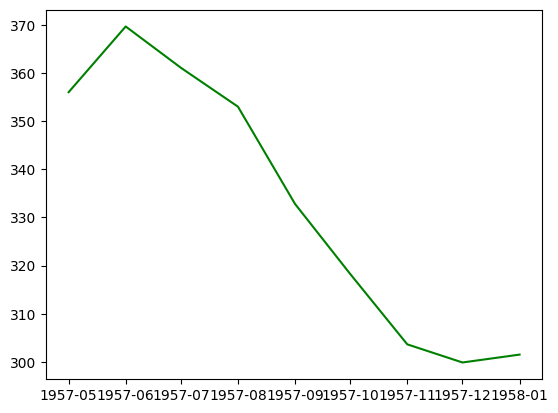

In [106]:
plt.plot(forecast, color= 'green') # lineplot for prediction